In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
C:\Users\khedi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open('subset1/eng.txt','rt') as f:
    text1 = f.read().lower()
with open('subset1/frn.txt','rt') as f:
    text2 = f.read().lower()
print('corpus length:', len(text1))
print('corpus length:', len(text2))


corpus length: 10746
corpus length: 12009


In [3]:
y1=np.tile(0,len(text1))
y2 = np.tile(1,len(text2))
x_train_eng, x_test_eng, y_train_eng, y_test_eng = train_test_split(text1, y1, test_size=0.2)
x_train_frn, x_test_frn, y_train_frn, y_test_frn = train_test_split(text2, y2, test_size=0.2)

In [4]:
print(len(x_train_eng), len(x_test_eng))

8596 2150


In [6]:
#generating english model
chars_eng = sorted(list(set(text1)))
chars_fr = sorted(list(set(text2)))
chars = sorted(list(set(chars_eng + chars_fr)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


##training set prepare
maxlen= 40
step = 1
sentences_eng_tr = []
next_chars_eng_tr = []
for i in range(0, int(0.8*len(text1)) - maxlen, step):
    sentences_eng_tr.append(text1[i: i + maxlen])
    next_chars_eng_tr.append(text1[i + maxlen])

print('nb sequences:', len(sentences_eng_tr))
##test set prepare
sentences_eng_test = []
string_eng_test= []
step_test=20
for i in range(int(0.8*len(text1)) - maxlen,len(text1) - maxlen-step_test, step_test):
    sentences_eng_test.append(text1[i: i + int(maxlen/2)]+text1[i+int(maxlen/2)+5:i+maxlen+5])
    string_eng_test.append(text1[i+int(maxlen/2):i+int(maxlen/2)+5])
print('nb sequences:', len(sentences_eng_test))

print('Vectorization...')
X_eng = np.zeros((len(sentences_eng_tr), maxlen, len(chars)), dtype=np.bool)
y_eng = np.zeros((len(sentences_eng_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_eng_tr):
    for t, char in enumerate(sentence):
        X_eng[i, t, char_indices[char]] = 1
    y_eng[i, char_indices[next_chars_eng_tr[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

total chars: 44
nb sequences: 8556
nb sequences: 107
Vectorization...
Build model...


In [7]:
#generating french model



##training set prepare
maxlen= 40
step = 1
sentences_fr_tr = []
next_chars_fr_tr = []
for i in range(0, int(0.8*len(text2)) - maxlen, step):
    sentences_fr_tr.append(text2[i: i + maxlen])
    next_chars_fr_tr.append(text2[i + maxlen])

print('nb sequences:', len(sentences_fr_tr))
##test set prepare
sentences_fr_test = []
string_fr_test= []
step_test=20
for i in range(int(0.8*len(text2)) - maxlen,len(text2) - maxlen, step_test):
    sentences_fr_test.append(text2[i: i + int(maxlen/2)]+text2[i+int(maxlen/2)+5:i+maxlen+5])
    string_fr_test.append(text2[i+int(maxlen/2):i+int(maxlen/2)+5])
    #sentences_eng_test.append(text1[i: i + maxlen/2]+text1[i+maxlen/2+5:i+maxlen+5])
    #string_eng_test.append(text1[i+maxlen/2:i+maxlen/2+5])
print('nb sequences:', len(sentences_fr_test))

print('Vectorization...')
X_fr = np.zeros((len(sentences_fr_tr), maxlen, len(chars)), dtype=np.bool)
y_fr = np.zeros((len(sentences_fr_tr), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences_fr_tr):
    for t, char in enumerate(sentence):
        X_fr[i, t, char_indices[char]] = 1
    y_fr[i, char_indices[next_chars_fr_tr[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(maxlen, len(chars))))
model2.add(Dense(len(chars)))
model2.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

nb sequences: 9567
nb sequences: 121
Vectorization...
Build model...


In [8]:
def vectorize(sentence, chars , char_indices ):
    X = np.zeros((1, maxlen, len(chars)), dtype=np.bool)
    for t, char in enumerate(sentence):
        X[0, t, char_indices[char]] = 1
    return X

In [9]:
def get_scores_for_model(seed,next_string, model,chars,char_indices):
    sentence =seed
    prob_char=0.0
    x = np.zeros((5, maxlen, len(chars)))

    x[0] = vectorize(seed,chars,char_indices)
    x[1] = vectorize(seed[1:]+next_string[:1],chars,char_indices)
    x[2] = vectorize(seed[2:]+next_string[:2],chars,char_indices)
    x[3] = vectorize(seed[3:]+next_string[:3],chars,char_indices)
    x[4] = vectorize(seed[4:]+next_string[:4],chars,char_indices)
    probs_term = []
    for i in range(5):
        preds = model.predict(x[i].reshape(1,maxlen,44), verbose=0)[0]
        preds = np.log(preds)
        probs_term.append(preds[char_indices[next_string[i]]])

    return probs_term
    '''
    prob_list.append(term_probs)
    
    for i in range(5):
        x = np.zeros((1, len(seed), len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = model.predict(x, verbose=0)[0]
        #print('Preds', preds)
        diversity = 1.0
        #print(seed, "\n", next_string)
        prob_char = prob_char + sample(preds, diversity,next_string[i],char_indices)
        sentence = sentence[1:] + next_string[i]
    '''
    return np.exp(prob_char)
        

In [10]:
import csv
# train the model, output generated text after each iteration
for iteration in range(1, 2):
    print()
    #print('-' * 50)
    print('Iteration', iteration)
    a1=model.fit(X_eng, y_eng,
              batch_size=128,
              epochs=20)
    model_eng_json = model.to_json()
    with open("model/model_eng_"+str(iteration)+".json", "w") as json_file:
        json_file.write(model_eng_json)
    # serialize weights to HDF5
    model.save_weights("weights/model_eng_"+ str(iteration) +".h5")
    print("Saved model to disk")


Iteration 1
Epoch 1/20
8556/8556 [==============================] - 14s - loss: 2.8650 - acc: 0.2055    
Epoch 2/20
8556/8556 [==============================] - 14s - loss: 2.2867 - acc: 0.3490    
Epoch 3/20
8556/8556 [==============================] - 14s - loss: 1.9692 - acc: 0.4369    
Epoch 4/20
8556/8556 [==============================] - 14s - loss: 1.7488 - acc: 0.4921    
Epoch 5/20
8556/8556 [==============================] - 14s - loss: 1.5594 - acc: 0.5355    
Epoch 6/20
8556/8556 [==============================] - 14s - loss: 1.4074 - acc: 0.5756    
Epoch 7/20
8556/8556 [==============================] - 14s - loss: 1.2772 - acc: 0.6152    
Epoch 8/20
8556/8556 [==============================] - 14s - loss: 1.1619 - acc: 0.6455    
Epoch 9/20
8556/8556 [==============================] - 14s - loss: 1.1664 - acc: 0.6771    
Epoch 10/20
8556/8556 [==============================] - 14s - loss: 0.9571 - acc: 0.7114    
Epoch 11/20
8556/8556 [==============================] -

In [11]:
    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]
    
    #sentence=
    prob_english=[]
    for i in range(len(sentences_eng_test)):
        prob_english.append(get_scores_for_model(sentences_eng_test[i], string_eng_test[i], model,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_english.append(get_scores_for_model(sentences_fr_test[i], string_fr_test[i], model, chars, char_indices))
    #sentence = text1[start_index: start_index + maxlen]
    #print (prob_english)
    np.savetxt("prob_eng/output_prob_" + str(iteration) + ".csv", prob_english, delimiter=',')
    #with open("prob_eng/output_prob_" + str(iteration) + ".csv", 'rt',newline='') as f:
    #    w = csv.writer(f, delimiter=',')
    #    for row in prob_english:
    #        w.writerow(row)
    with open("model/loss_eng" + ".csv", 'a') as f:
        w = csv.writer(f, delimiter=',')
        w.writerow(a1.history['loss'])
       
        #print()

In [12]:

import csv
# train the model, output generated text after each iteration


for iteration in range(1, 2):
    print()
    #print('-' * 50)
    print('Iteration', iteration)
    a2=model2.fit(X_fr, y_fr,
              batch_size=128,
              epochs=20)
    model_fr_json = model2.to_json()
    with open("model/model_fr_"+str(iteration)+".json", "w") as json_file:
        json_file.write(model_fr_json)
    # serialize weights to HDF5
    model2.save_weights("weights/model_fr_"+ str(iteration) +".h5")
    print("Saved model to disk")
    sentences_fr_test =sentences_fr_test[:100]
    string_fr_test=string_fr_test[:100]
    sentences_eng_test =sentences_eng_test[:100]
    string_eng_test=string_eng_test[:100]

        
    
    #sentence=
    prob_fr=[]
    for i in range(len(sentences_eng_test)):
        prob_fr.append(get_scores_for_model(sentences_eng_test[i], string_eng_test[i], model2,chars, char_indices))
    for i in range(len(sentences_fr_test)):
        prob_fr.append(get_scores_for_model(sentences_fr_test[i], string_fr_test[i], model2, chars, char_indices))
    #sentence = text1[start_index: start_index + maxlen]
    #print (prob_english)
    np.savetxt("prob_fr/output_prob_" + str(iteration) + ".csv", prob_fr, delimiter=',')
    #with open("prob_fr/output_prob_" + str(iteration) + ".csv", 'wt') as f:
    #    w = csv.writer(f, delimiter=',')
    #    for row in prob_fr:
    #        w.writerow(row)
    with open("model/loss_fr" + ".csv", 'a') as f:
        w = csv.writer(f, delimiter=',')
        w.writerow(a2.history['loss'])

    #print()


Iteration 1
Epoch 1/20
9567/9567 [==============================] - 15s - loss: 2.7232 - acc: 0.2241    
Epoch 2/20
9567/9567 [==============================] - 16s - loss: 2.1756 - acc: 0.3575    
Epoch 3/20
9567/9567 [==============================] - 15s - loss: 1.8945 - acc: 0.4285    
Epoch 4/20
9567/9567 [==============================] - 16s - loss: 1.7115 - acc: 0.4720    
Epoch 5/20
9567/9567 [==============================] - 16s - loss: 1.5632 - acc: 0.5202    
Epoch 6/20
9567/9567 [==============================] - 16s - loss: 1.4247 - acc: 0.5558    
Epoch 7/20
9567/9567 [==============================] - 16s - loss: 1.3016 - acc: 0.5951    
Epoch 8/20
9567/9567 [==============================] - 16s - loss: 1.1913 - acc: 0.6279    
Epoch 9/20
9567/9567 [==============================] - 16s - loss: 1.1239 - acc: 0.6554    
Epoch 10/20
9567/9567 [==============================] - 16s - loss: 0.9950 - acc: 0.6847    
Epoch 11/20
9567/9567 [==============================] -

In [13]:
def predict_language(prob_english, prob_fr):
    #print(len(prob_english))
    y = [1] * len(prob_english)
    probs_eng = []
    probs_frn = []
    for i in range(len(prob_english)):
        sum_english = 0
        sum_fr = 0
        #print(len(prob_english[0]))
        for j in range(len(prob_english[0])):
            #print(i)
            #print(j)
            sum_english += float(prob_english[i][j])
            sum_fr += float(prob_fr[i][j])
        sum_english = np.exp(sum_english)
        sum_fr = np.exp(sum_fr)
        if sum_english < sum_fr:
            y[i] = 0
        if sum_fr == 0.0:
            sum_fr = 0.0000000000001
            #print(str(i) + "Zero")
        probs_eng.append(sum_english)
        probs_frn.append(sum_fr)
    return y, probs_eng, probs_frn

----------------- Iteration: 1 --------------------
7.04332821988e-27 0.0465689831439
[[68 32]
 [30 70]]
0.69


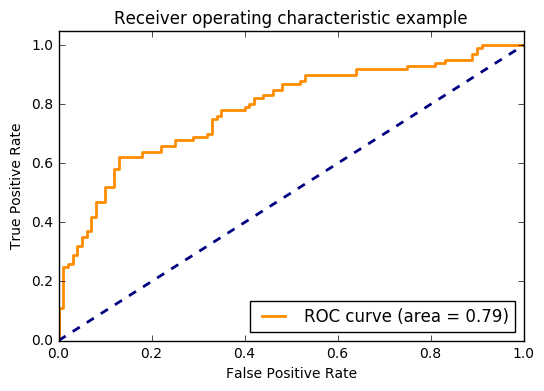

In [14]:
import csv
for iter in range(1,2):
    print("----------------- Iteration: " + str(iter) + " --------------------")
    prob_english=[]
    with open("prob_eng/output_prob_" + str(iter) + ".csv", 'rt') as f:
            w = csv.reader(f, delimiter=',')
            prob_english = list(w)
    #print(prob_english)

    prob_fr=[]
    with open("prob_fr/output_prob_" + str(iter) + ".csv", 'rt') as f:
            w = csv.reader(f, delimiter=',')
            prob_fr = list(w)
    
    #print((prob_english), len(prob_fr))
    true_labels = ([1] * 100) + ([0] * 100)
    #print(true_labels.shape)

    from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, auc, roc_curve
    #try:
    pred_y, logprob_english, logprob_fr = predict_language(prob_english, prob_fr)
    #except:
    #    continue
    #x = [e for i, e in enumerate(logprob_fr) if e == 0]
    #print(x)
    print(min(logprob_fr), max(logprob_fr))
    y_hat = np.array([a/b for (a, b) in zip(logprob_english, logprob_fr)])
    #roc_auc_score(true_labels, y_hat)
    
    print (confusion_matrix(true_labels, pred_y))
    print (accuracy_score(true_labels, pred_y))
    #print (y_hat)
    try:
        fpr, tpr, _ = roc_curve(true_labels, y_hat)
    except:
        continue
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()